# 1.
First I will install packages. First the usual triplet. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(777)

Packages for splitting dataset, performing cross validation with grid search. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

The first one is for gradient boosted random forest. The second one, tensorflow, is the library for neural networks. Keras is a frontend to tensorflow that further adds convenience. I will use a sequential model with densely connected layers. The activation is also thought of as a layer.  

In [3]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Now we will take a look at the data.

In [4]:
data0 = pd.read_csv("RawDataSet.csv")
list(data0)

['seller_id',
 'user_status',
 'days_since_joined',
 'total_orders',
 'total_order_value',
 'total_listings',
 'total_followers',
 'total_brands_shown',
 'total_categories_shown',
 'current_listings_shown',
 'current_brands_shown',
 'current_categories_shown',
 'total_follows',
 'total_int_shares',
 'total_ext_shares',
 'binary_response']

In [5]:
data1 = data0.dropna(axis=0, how='any')
(data0.shape,data1.shape, 1-len(data1)/len(data0))

((5749, 16), (5499, 16), 0.04348582362149944)

Less than 5% of the samples has missing data. I will go on to do the analysis using samples with complete data.

In [6]:
data1.iloc[:,:7].head(1)

,seller_id,user_status,days_since_joined,total_orders,total_order_value,total_listings,total_followers
1,2,posh_pro,2391.0,668.0,1676.94,626.0,4005.0


In [7]:
data1.iloc[:,7:11].head(1)

,total_brands_shown,total_categories_shown,current_listings_shown,current_brands_shown
1,94.0,30.0,31.0,6.0


In [8]:
data1.iloc[:,11:].head(1)

,current_categories_shown,total_follows,total_int_shares,total_ext_shares,binary_response
1,14.0,41.0,40.0,0.0,0


Survey of the data shows that I can remove the first column. The last column would be the response. The column that would need work on is 'user_status'. 

In [9]:
list(set(data1['user_status']))

['removed', 'posh_pro', 'qualified']

In [10]:
sum(data1['user_status'] == 'posh_pro'),sum(data1['user_status'] == 'qualified')
sum(data1['user_status'] == 'removed')
for x in set(data1['user_status']):
    print(sum(data1['user_status'] == x))

10
5100
389


In [11]:
data2 = data1[data1['user_status'] != 'removed']

Since there are only 10 of 'removed' I will remove it. The name some what supports this decision. I am guessing that 'posh_pro' is more prestigeous than 'qualified'. Although I would not expect so much more 'posh_pro' than 'qualified'.   

In [12]:
data3 = data2.iloc[:, 2:-1]
user_status = (data2['user_status'] == 'qualified')
X = pd.concat([user_status, data3], axis=1)
Y = data2['binary_response']
True==1

True

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=0)

I labeled 'user_status' to be 1 if 'qualified' and 0 if 'posh_pro'. I removed the index column and separated the data into the predictors and the response. I will use a training set to learn the parameters. I will compare the results of this on a test set. 40% of the data will be used for testing. 

### Gradient Boosted Random Forest
The model is such that a voting is done with multiple classification trees.

In [14]:
import warnings
warnings.filterwarnings("ignore")
forest = xgb.XGBClassifier()
forest_cv = GridSearchCV(forest, {'max_depth': range(
    1, 15), 'n_estimators': [10, 50, 100, 200, 500, 800]})
forest_cv.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 15), 'n_estimators': [10, 50, 100, 200, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

I will try depth of 1 up to 14, and 6 different values from 10 to 800 for the number of trees. 

In [15]:
print(forest_cv.best_params_, forest_cv.best_score_)

{'max_depth': 2, 'n_estimators': 50} 0.7810507136349834


The best one chosen had a depth of 2 and number of trees 50. 

Below is the confusion table for the best model. The count of true negatives is at (0,0), false negatives is at (1,0), true positives is at (1,1) and false positives is at (0,1).

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
forest = xgb.XGBClassifier(**forest_cv.best_params_)
forest.fit(X_train, Y_train)
confusion_matrix(Y_test, forest.predict(X_test))

array([[1033,  261],
       [ 234,  668]])

An example tree.

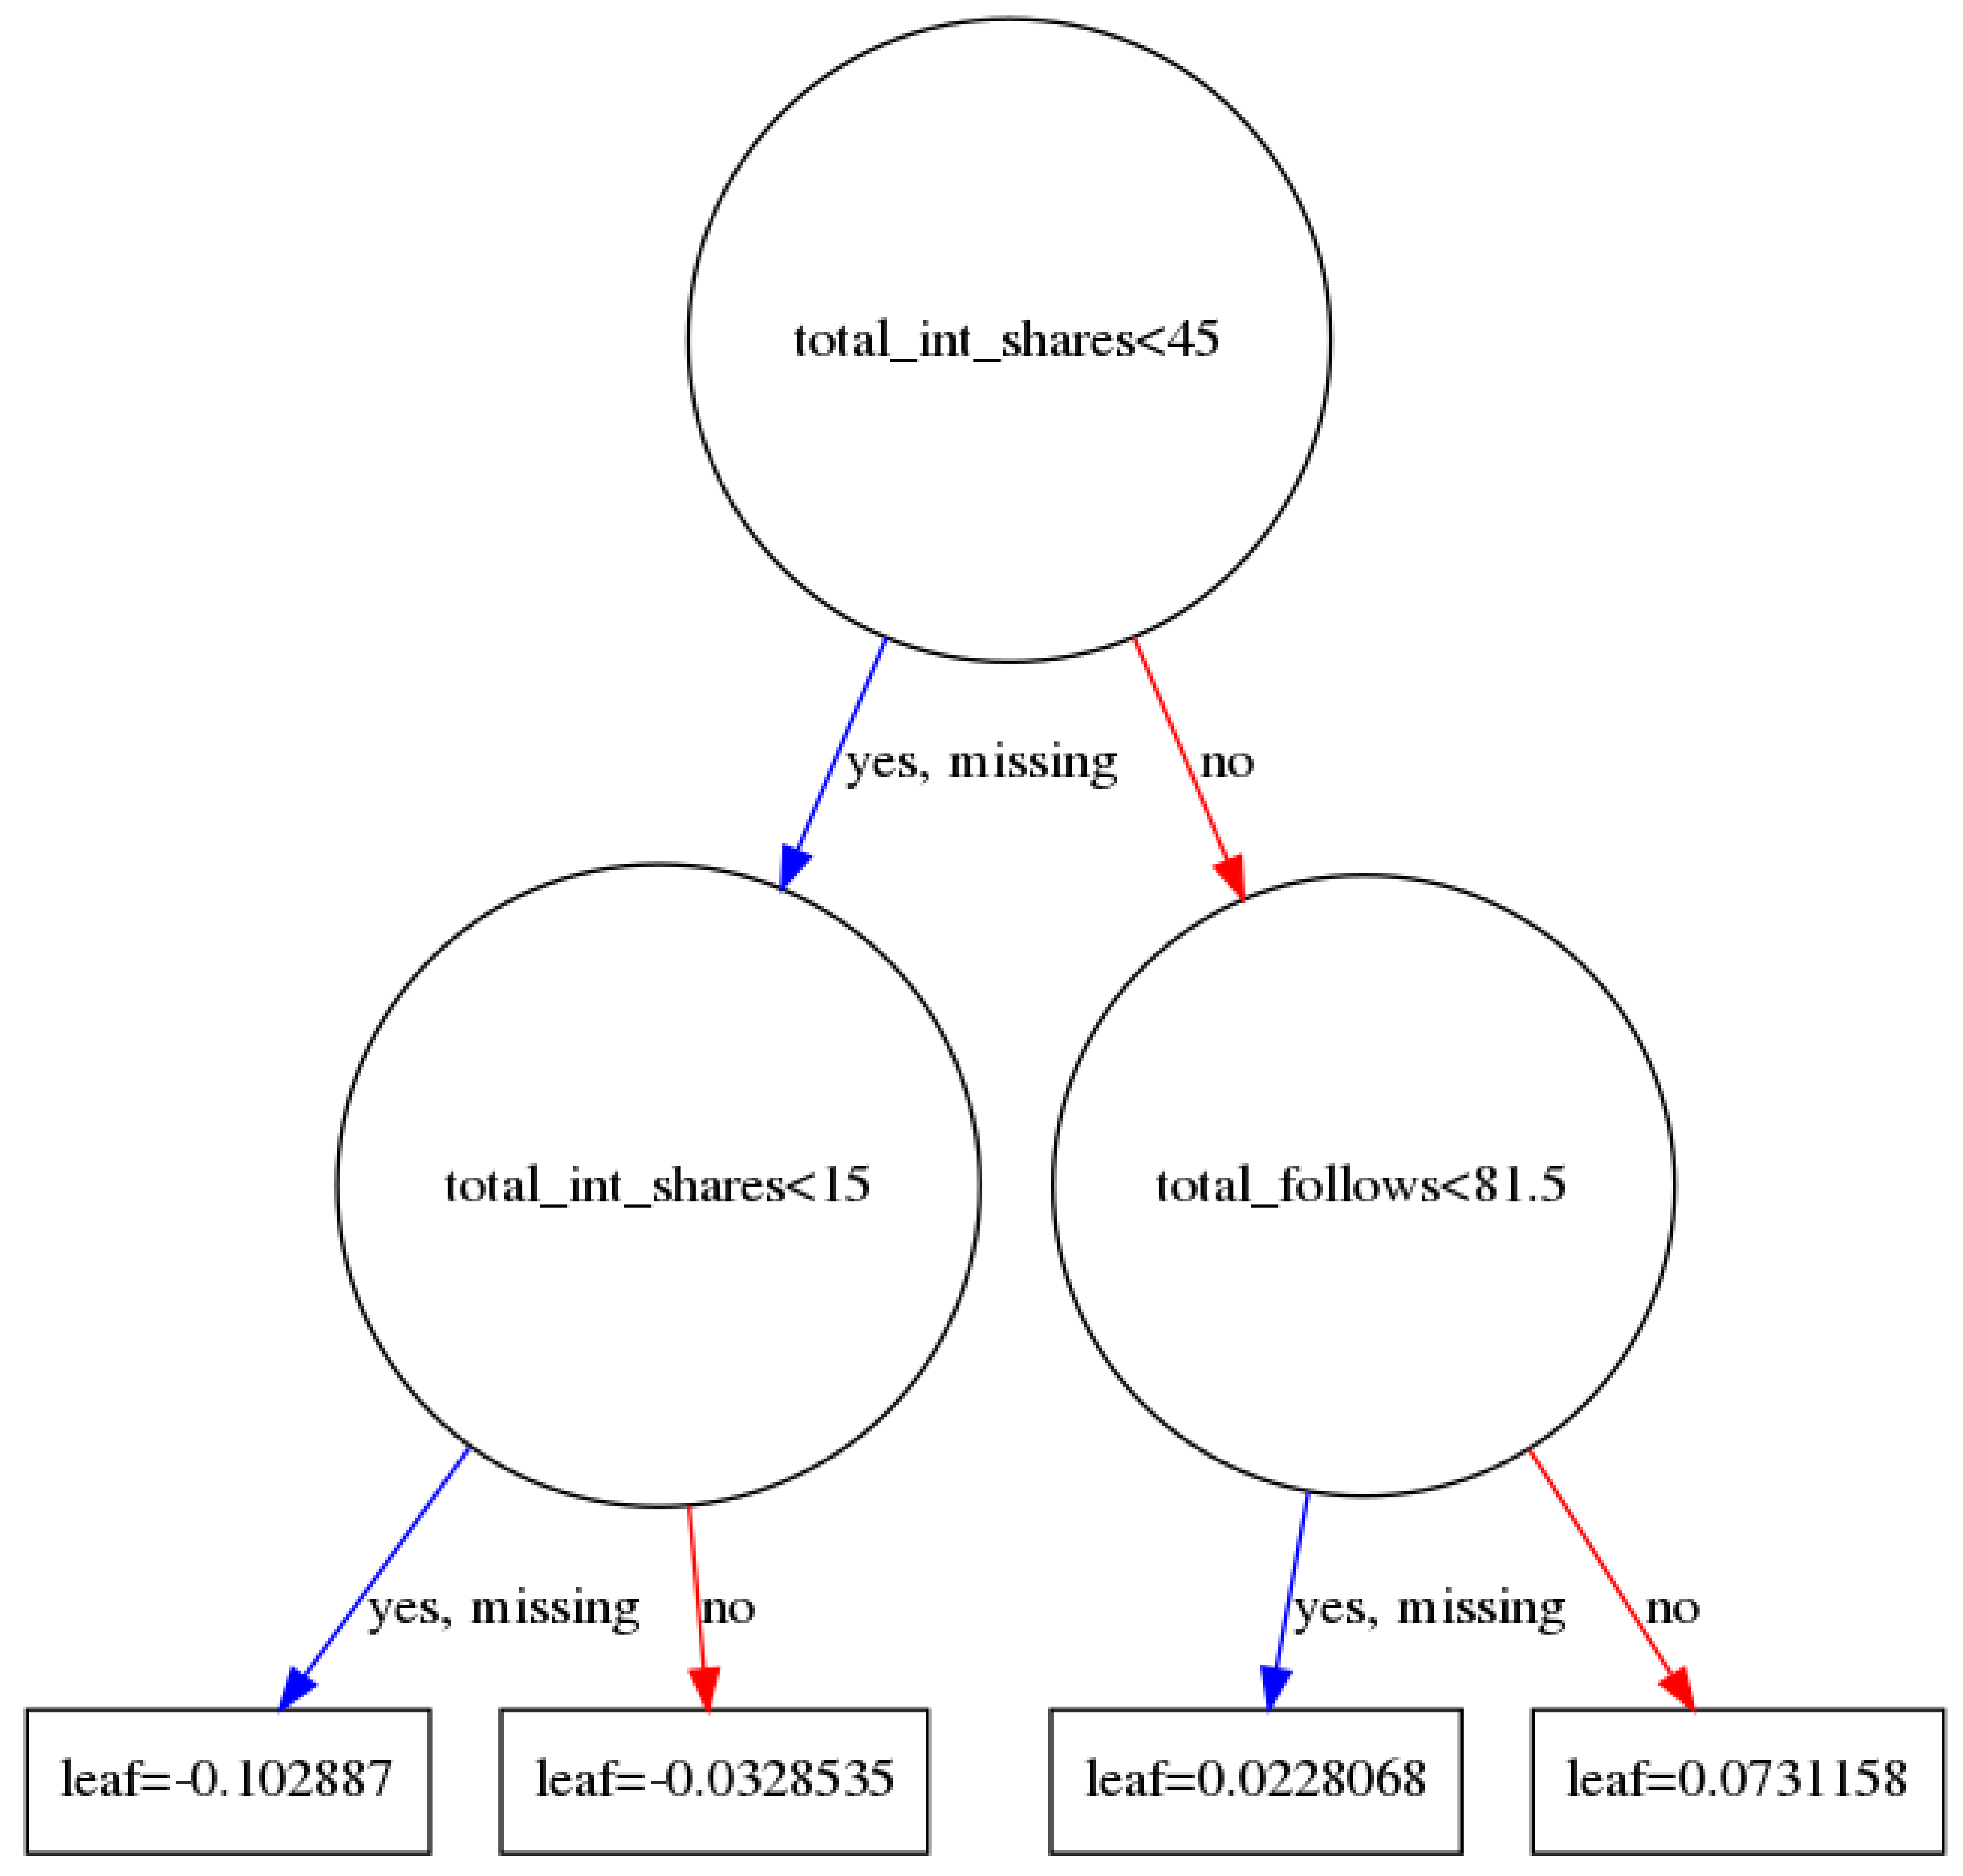

In [17]:
from xgboost import plot_tree
plot_tree(forest._Booster, num_trees=7)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [18]:
f1_score(1-Y_test, 1-forest.predict(X_test))

0.8067161265130809

In [19]:
f1_score(Y_test, forest.predict(X_test))

0.7296559257236482

$F_1$ scores are somewhat wierd to me, as switching 0 and 1 will result in a different value. So I looked at both. 

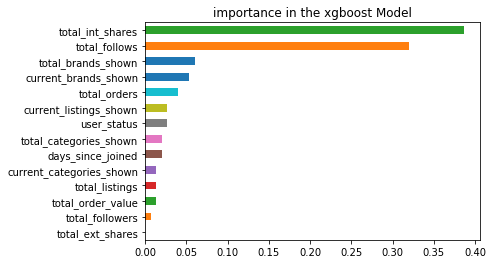

In [20]:
importances = pd.Series(forest.feature_importances_, index=list(X))
importances = importances.sort_values()
importances.plot(kind="barh")
plt.title("importance in the xgboost Model")
plt.show()

Total internal shares and total followers seem to be the variables that affect whether a new feature is taken up. Looking at the importance plot, measure of involvement in the application seems to have an affect.

### Neural Network
This is a method where you Afinely map an input, then transform nonlinearly by an activation function. The pair of these operations are repeated.

In [21]:
X_newtrain, X_val, Y_newtrain, Y_val = train_test_split(
    X_train, Y_train, test_size=0.4, random_state=0)

We split the training dataset, 60% of which as the inner training set and 40% of which as the validation set.

In [22]:
results = np.zeros((2, 3, 3, 3))
activations = ["relu", "sigmoid"]
epcs = [10, 50, 100]
bs = [10, 50, 100]
ns = [[14, 14, 14], [14, 8, 4], [14, 20, 14]]

I will try different models on the inner training set and choose the one that had the best performance on the validation set. I will try the rectified linear unit and the sigmoid for activation. I will try 3 different epoch sizes and batch sizes respectively. I will also try 3 different hidden layer structure. One where the number of nodes stay constant, one where it decreases, and one where it increases and then decreases.  

In [23]:
from keras.utils import to_categorical
Y_newtrain_oh=to_categorical(Y_newtrain, num_classes=2)
from keras.layers import Dropout
for i in range(2):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                model = Sequential()
                model.add(Dense(ns[l][0], input_dim=14))
                model.add(Activation(activations[i]))
                model.add(Dense(ns[l][1]))
                model.add(Activation(activations[i]))
                model.add(Dense(ns[l][2]))
                model.add(Activation(activations[i]))
                model.add(Dense(units=2,activation='softmax'))
                model.compile(loss='binary_crossentropy',
                              optimizer="adam", metrics=['binary_accuracy'])
                model.fit(X_newtrain.values, Y_newtrain_oh,
                          epochs=epcs[j], batch_size=bs[l], verbose=0)
                results[i, j, k, l] = (f1_score(argmax(model.predict(X_val.values),1),Y_val.values)
                                    +f1_score(1-argmax(model.predict(X_val.values),1),1-Y_val.values))/2
                print(i,j,k,l,results[i, j, k, l])

0 0 0 0 0.3768310331122382
0 0 0 1 0.3750592697961119
0 0 0 2 0.3750592697961119
0 0 1 0 0.3750592697961119
0 0 1 1 0.2856368563685637
0 0 1 2 0.3750247990498517
0 0 2 0 0.2856368563685637
0 0 2 1 0.2856368563685637
0 0 2 2 0.560123326937747
0 1 0 0 0.5109500250501002
0 1 0 1 0.3771311310447933
0 1 0 2 0.3771311310447933
0 1 1 0 0.3750592697961119
0 1 1 1 0.3812539196186995
0 1 1 2 0.3750592697961119
0 1 2 0 0.3750592697961119
0 1 2 1 0.7292171368736496
0 1 2 2 0.2856368563685637
0 2 0 0 0.3907908616588727
0 2 0 1 0.2856368563685637
0 2 0 2 0.37653066709670485
0 2 1 0 0.3750592697961119
0 2 1 1 0.6912742549718914
0 2 1 2 0.3750592697961119
0 2 2 0 0.3750592697961119
0 2 2 1 0.2852494577006508
0 2 2 2 0.3750592697961119
1 0 0 0 0.5683885700449056
1 0 0 1 0.3750592697961119
1 0 0 2 0.3750592697961119
1 0 1 0 0.47674874630320163
1 0 1 1 0.3750592697961119
1 0 1 2 0.3750592697961119
1 0 2 0 0.5009923685240149
1 0 2 1 0.3750592697961119
1 0 2 2 0.3750592697961119
1 1 0 0 0.6536832270233934


In [24]:
np.where(results == np.amax(results))

(array([0]), array([1]), array([2]), array([1]))

The best one selected has relu activation, 50 epochs, batch size 100, and a tapering neuron numbers as layers proceed.

In [25]:
Y_train_oh=to_categorical(Y_train, num_classes=2)
model = Sequential()
model.add(Dense(14, input_dim=14))
model.add(Activation("sigmoid"))
model.add(Dense(8))
model.add(Activation("sigmoid"))
model.add(Dense(4))
model.add(Activation("sigmoid"))
model.add(Dense(units=2,activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer="adam", metrics=['binary_accuracy'])
history=model.fit(X_train.values, Y_train_oh, epochs=50, batch_size=100, verbose=0)

The importance of the variables are hidden, but you could still look at the weights to judge importance of the variables. Below is the confusion table. It does not do as well as the forest. The count of true negatives is at(0,0), false negatives is at (1,0), true positives is at (1,1) and false positives is at (0,1).

In [26]:
predict0=argmax(model.predict(X_test.values),1)
confusion_matrix(predict0, Y_test.values)

array([[928, 415],
       [366, 487]])

Below is to check the convergence of the model. Probably more computation will be helpful.

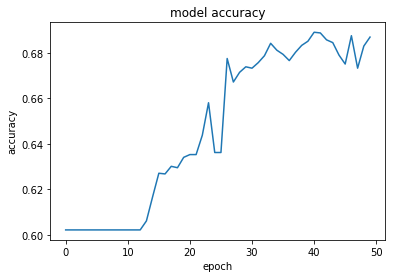

In [27]:
plt.plot(history.history['binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

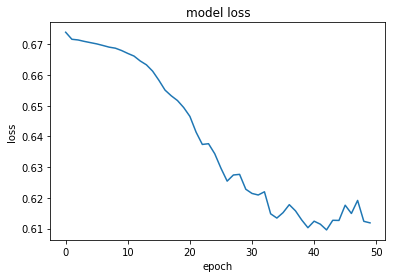

In [28]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In the future I would like to...
* do a more extensive search for the neural network parameters
* come up with a measure of user involvement and use that instead
* come up with a better measure of an optimality of the model

# 2.1
I did not know how to do this. So I consulted [this](https://stackoverflow.com/questions/48205033/get-second-highest-salary-for-each-person-in-mysql?rq=1). The endorsed solution has a link to a [demo](http://sqlfiddle.com/#!9/d97968/1). The nature of the problem is identical to the one being asked. 
```mysql
SELECT A.*
FROM Order_Details A
JOIN Order_Details B ON A.Seller_id = B.Seller_id
GROUP BY A.Seller_id, A.Create_time
HAVING sum(A.Create_time > B.Create_time) = 1
```

# 2.2
Again for this, I searched online. I consulted [here](https://stackoverflow.com/questions/35374860/join-select-ue-on-1-1). It would return 1500 rows, as it will list all possible pairs of selecting one each from User_details and Order_details. 